# Predicting Surname Ethnicities Revisited!

### Objective: This notebook is dedicated to predicting the national origin of a surname based solely on the spelling of the name. 

This is a continuation of the other notebook that explored predicting surname origin. The past one used a random forrest whereas this notebook will use a neural network. This notebook will take training data from 5 different countries; Germany, France, Spain, England, and Italy. The names were sourced from the web. We will see how well the neural network predicts the national origin of a name!

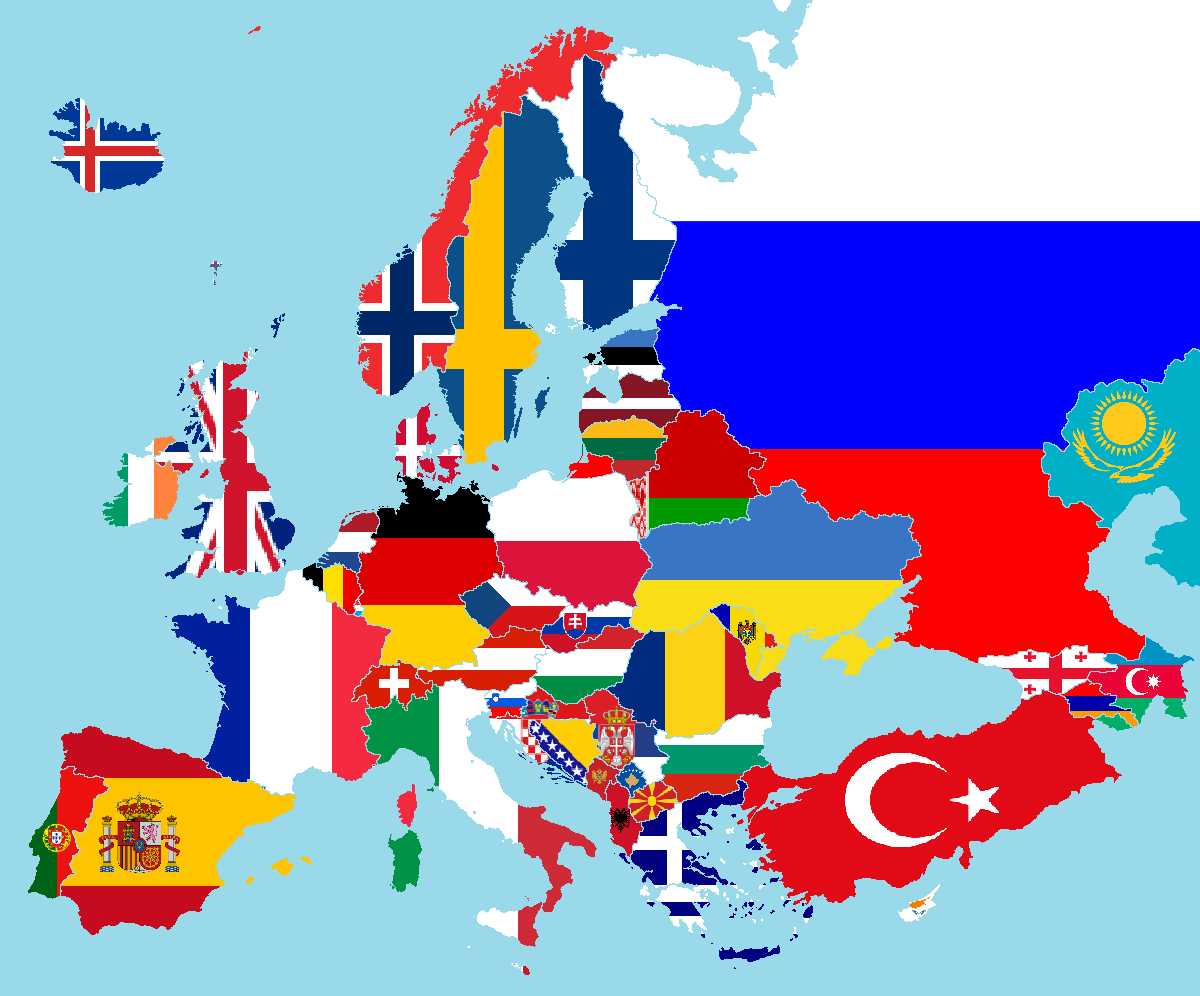

In [115]:
import IPython
url = 'https://user-images.githubusercontent.com/58672183/76170187-eb899c00-6155-11ea-82e8-55e46a5c589a.png'
IPython.display.Image(url, width = 500)

### Sourcing the Surnames

The surnames were sourced through this website. 
https://www.familyeducation.com/baby-names/browse-origin/surname
The surnames were webscraped and output to a csv.


In [116]:
import matplotlib.pyplot as plt #load in packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense

import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
%matplotlib inline

### The Dataset

Let's load in the data and see the selection of surnames and the counts of each national origin.

In [117]:
surnames = pd.read_csv(r'C:\Users\Daniel_Heffley\Desktop\Predict Good Matches\Surnames DF.csv')

In [118]:
surnames[surnames['Class'] == 0].head()#German

,Name,Class
0,Abbas,0
1,Abbe,0
2,Abegglen,0
3,Abel,0
4,Abeln,0


In [119]:
surnames[surnames['Class'] == 1].head()#French

,Name,Class
12275,Abbe,1
12276,Acord,1
12277,Acy,1
12278,Adrien,1
12279,Agard,1


In [120]:
surnames[surnames['Class'] == 2].head()#Spanish

,Name,Class
15287,Abad,2
15288,Abalos,2
15289,Abar,2
15290,Abascal,2
15291,Abeita,2


In [121]:
surnames[surnames['Class'] == 3].head()#English

,Name,Class
17248,Abbe,3
17249,Abbett,3
17250,Abbey,3
17251,Abbitt,3
17252,Abbot,3


In [122]:
surnames[surnames['Class'] == 4].head()#Italian

,Name,Class
29570,Abate,4
29571,Abato,4
29572,Abbruzzese,4
29573,Abela,4
29574,Abella,4


In [123]:
surnames.shape

(34307, 2)

In [124]:
surnames.Class.value_counts()

3    12322
0    12275
4     4737
1     3012
2     1961
Name: Class, dtype: int64

There are duplicate names in the dataset. This is due to some surnames being used in multiple countries. I eliminated all of the duplicate surnames in the dataset so that every surname belongs to just one class.

In [125]:
surnames.drop_duplicates(subset=['Name'], keep=False, inplace = True)

In [126]:
surnames.Class.value_counts()

0    11322
3    11228
4     4552
1     2545
2     1751
Name: Class, dtype: int64

In [127]:
surnames.shape

(31398, 2)

After eliminating the duplicates, we can calculate the baseline accuracy for the model. German names have the largest share in this dataset at 36%. The classes are unbalanced right now, but later on this will be aleviated with oversampling.

In [128]:
11322/31398

0.3605962163195108

### Creating the Model

First, we must make the surnames the feature and the class our target variable.

In [129]:
X = surnames.Name #We create the feature and target
y = surnames.Class

# Split the new DataFrame into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size = .1)

The surnames must be tokenzied in order to make a document term matrix of the features. The tokenizer used splits all of the surnames into groups of two letters.

In [130]:
import re

def ngrams(string, n=2):
    string = re.sub(r'[,-./]|\sBD',r'', string)#This step just does some string cleaning
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

In [131]:
ngrams('Muller')

['Mu', 'ul', 'll', 'le', 'er']

We use the term frequency inverse document frequency vectorizer to make numeric features for the surnames.

In [132]:
vect = TfidfVectorizer(analyzer = ngrams)

# Create document-term matrices.
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [133]:
n_input = X_train_dtm.shape[1]
n_input #There are 842 features in the document term matrix

842

Before we input our target variables into the neural network, we must one-hot encode them.

In [134]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [135]:
y_train.shape

(28258,)

In [136]:
y_test.shape

(3140,)

We can now set up our neural network. It worked best when there was one hidden layer and a softmax activation for the final layer.

In [137]:
from keras import losses
import keras

In [138]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential([
    Dense(n_input, input_shape=(n_input,)),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    #Dense(20),
    #Activation('relu'),
    Dense(5),
    Activation('softmax'),
])

In [139]:
adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [140]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])

### Oversampling and Running the Model

As the training data is imbalanced with more German and English surnames, we have to oversample the minority classes. This is done with SMOTE, which creates artifical data points that are similar to the real ones in the data. After that, the neural network with the augmented data is used to train the model. 

In [141]:
import imblearn
from imblearn.over_sampling import SMOTE

In [142]:
sm = SMOTE(random_state=12)
X_train_res, y_train_res = sm.fit_sample(X_train_dtm, y_train_one_hot)

In [143]:
history = model.fit(
    X_train_res,
    y_train_res,
    validation_data=(X_test_dtm, y_test_one_hot),
    epochs=12,
    batch_size=None,
    verbose=1
)

Train on 50835 samples, validate on 3140 samples
Epoch 1/12
50835/50835 [==============================] - 25s 492us/step - loss: 0.8670 - acc: 0.7137 - val_loss: 0.5943 - val_acc: 0.7717
Epoch 2/12
50835/50835 [==============================] - 24s 481us/step - loss: 0.4510 - acc: 0.8386 - val_loss: 0.5236 - val_acc: 0.8045
Epoch 3/12
50835/50835 [==============================] - 26s 513us/step - loss: 0.3678 - acc: 0.8701 - val_loss: 0.4901 - val_acc: 0.8188
Epoch 4/12
50835/50835 [==============================] - 21s 422us/step - loss: 0.3125 - acc: 0.8922 - val_loss: 0.4741 - val_acc: 0.8226
Epoch 5/12
50835/50835 [==============================] - 21s 419us/step - loss: 0.2678 - acc: 0.9093 - val_loss: 0.4515 - val_acc: 0.8312
Epoch 6/12
50835/50835 [==============================] - 24s 473us/step - loss: 0.2300 - acc: 0.9243 - val_loss: 0.4354 - val_acc: 0.8385
Epoch 7/12
50835/50835 [==============================] - 24s 467us/step - loss: 0.1976 - acc: 0.9359 - val_loss: 0.4

The validation accuracy gets to 86%, meaning that the neural network predicts the national origin of the name in the test set 86 percent of the time.

We also see in the below codeblock that the classes used to train the model were completely balanced.

In [30]:
german = 0
french = 0
spanish = 0
english = 0
italian = 0
for item in y_train_res:
    if item[0] == 1:
        german = german + 1
    if item[1] == 1:
        french = french + 1
    if item[2] == 1:
        spanish = spanish + 1
    if item[3] == 1:
        english = english + 1
    if item[4] == 1:
        italian = italian + 1
print('german =',german)
print('french =',french) 
print('spanish =',spanish)
print('english =',german)
print('italian =',italian)
        

german = 10167
french = 10167
spanish = 10167
english = 10167
italian = 10167


### Reviewing the Predictions

In [31]:
model.predict(X_test_dtm) #Demonstration of how the network predictions are displayed

array([[9.99992609e-01, 8.68847716e-10, 2.35854630e-12, 7.37128448e-06,
        9.74030122e-15],
       [7.90852427e-01, 1.83209911e-01, 6.55846861e-06, 2.59273686e-02,
        3.69191230e-06],
       [4.19060094e-03, 3.85935598e-12, 3.87356341e-10, 9.95809436e-01,
        7.41400691e-11],
       ...,
       [7.22707808e-02, 6.51612764e-09, 1.83212734e-07, 9.27723467e-01,
        5.63659660e-06],
       [3.86558861e-01, 3.80110830e-01, 1.32002356e-03, 2.29983434e-01,
        2.02686666e-03],
       [1.31826755e-02, 9.67260778e-01, 9.62600607e-05, 1.94584541e-02,
        1.84495195e-06]], dtype=float32)

In [32]:
import numpy as np

In [33]:
probas = model.predict(X_test_dtm)
labels = np.argmax(probas, axis=-1)    
print(labels) #Output the class predictions into an array

[0 0 3 ... 3 0 1]


In [34]:
len(labels)

3140

In [35]:
test_results = pd.DataFrame(columns = ['Name','class','class_pred'])#put the predictions in a dataframe

In [36]:
test_results['Name'] = X_test

In [37]:
test_results['class'] = y_test

In [38]:
test_results['class_pred'] = labels

In [38]:
test_results.to_csv('test_results_surnames_NN_.csv',index = False)

Let's look at a selection of incorrect predictions

In [39]:
wrong_predictions = test_results[test_results['class'] != test_results['class_pred']]#Create wrong prediction dataframe

As a reminder, the classes are:

- German: 0
- French: 1
- Spanish: 2
- English: 3
- Italian: 4

In [40]:
wrong_predictions.head(20) #class is the true national origin and class_pred is the neural network prediction

,Name,class,class_pred
19998,Dier,3,0
6833,Maner,0,3
24265,Markland,3,1
11735,Weygand,0,3
6186,Lais,0,1
20906,Forte,3,1
29134,Wilken,3,0
11585,Welle,0,3
13798,Josserand,1,3
1811,Dolen,0,3


Some of the incorrect predictions seem to forgiveable as the names don't sound especially beholden to one country

We can also see in the below codeblocks that the incorrect predictions just tend to be shorter names on average than the correct predictions. This makes sense given that less letters in the name means less features that can be used.

In [41]:
right_predictions = test_results[test_results['class'] == test_results['class_pred']]#Create right prediction dataframe

In [42]:
wrong_predictions.reset_index(inplace = True)
i = 0
wrong_predictions_string_len = []
for i in range(wrong_predictions.shape[0]):
    length_of_string = len(str(wrong_predictions.loc[i,'Name']))
    wrong_predictions_string_len.append(length_of_string)
    i = i + 1
    
print('Incorrect predictions have an average string length of',round(np.mean(wrong_predictions_string_len),2))

Incorrect predictions have an average string length of 6.13


In [43]:
right_predictions.reset_index(inplace = True)
i = 0
right_predictions_string_len = []
for i in range(right_predictions.shape[0]):
    length_of_string = len(str(right_predictions.loc[i,'Name']))
    right_predictions_string_len.append(length_of_string)
    i = i + 1
    
print('Correct predictions have an average string length of', round(np.mean(right_predictions_string_len),2))

Correct predictions have an average string length of 6.91


We see here the breakdown by national origin of the predictions. The minority classes from the original dataset were not predicted as well as the larger classes. Perhaps more names need to be used to train these classes better.

In [44]:
right_predictions[(right_predictions['class'] == 0) == True].shape[0] #number of correct German predictions

1009

In [45]:
wrong_predictions[(wrong_predictions['class'] == 0) == True].shape[0] #number of incorrect German predictions

146

In [46]:
right_predictions[(right_predictions['class'] == 1) == True].shape[0] #number of correct French predictions

187

In [47]:
wrong_predictions[(wrong_predictions['class'] == 1) == True].shape[0] #number of incorrect French predictions

52

In [48]:
right_predictions[(right_predictions['class'] == 2) == True].shape[0] #number of correct Spanish predictions

134

In [49]:
wrong_predictions[(wrong_predictions['class'] == 2) == True].shape[0] #number of incorrect Spanish predictions

50

In [50]:
right_predictions[(right_predictions['class'] == 3) == True].shape[0] #number of correct English predictions

985

In [51]:
wrong_predictions[(wrong_predictions['class'] == 3) == True].shape[0] #number of incorrect English predictions

148

In [52]:
right_predictions[(right_predictions['class'] == 4) == True].shape[0] #number of correct Italian predictions

372

In [53]:
wrong_predictions[(wrong_predictions['class'] == 4) == True].shape[0] #number of incorrect Italian predictions

57

### Human Predictions vs. Neural Network Predictions

It's important to measure this model against the accuracy a human would have in categorizing names by country. This is precisely what I did in the following data frame. I took a selection of 100 surnames from the test set and compared my human predictions to the neural network predictions.

In [54]:
human_v_nn = pd.read_csv(r'C:\Users\Daniel_Heffley\Desktop\Predict Good Matches\Human Predictions v NN.csv')

In [55]:
human_v_nn.shape

(100, 6)

In [56]:
human_v_nn.head(20)#The first 20 human vs neural network predictions

,Name,class,human_pred,neural_network_pred,Good Guess Machine?,Good Guess Human?
0,Palfreyman,english,english,english,yes,yes
1,Reising,german,german,german,yes,yes
2,Woulfe,english,english,english,yes,yes
3,Brasel,german,german,german,yes,yes
4,Keisler,german,german,german,yes,yes
5,Airey,german,english,french,no,no
6,Markham,english,english,english,yes,yes
7,Rusche,german,german,german,yes,yes
8,Gutierez,spanish,spanish,spanish,yes,yes
9,Stull,german,german,english,no,yes


The neural network categorized 84% of the surnames in this set correctly and I categorized 87% of the surnames in this set correctly. Interestingly, many of the names the neural network miscategorized I also miscategorized.

### Conclusion

The neural network predicted the national origin of the surnames in the test set correctly 86% percent of the time. This result is actually very good considering that I categorized the surnames correctly 87% of the time. The network is basically as good as I am at categorizing the names. In the future, I can get even more surnames and see if the model's accuracy can keep up with a human's categorization accuracy.

In [247]:
model.predict(vect.transform(['Seaman']))

array([[8.3665358e-04, 2.0716320e-07, 6.0363933e-03, 9.9308139e-01,
        4.5329933e-05]], dtype=float32)